In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import math

from IPython import display
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.data import Dataset

In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

### Load data

In [4]:
df = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

In [5]:
# randomize data just to be sure not to get any pathological ordering effects
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

In [6]:
# some feature engineering
df["median_house_value"] /= 1000.0
df["rooms_per_person"] = (df["total_rooms"] / df["population"]).clip(0, 5)

In [7]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3,1.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0,0.7
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0,0.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4,1.5
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4,1.9
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0,2.3
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0,5.0


### Define input function

This controls how data is batched and shuffled during model training

In [8]:
def get_quantiles(x, n):
    return np.unique(np.percentile(x, q=np.arange(1, n)/n)).tolist()

def mk_feature_columns():

    population = tf.feature_column.numeric_column("population")
    households = tf.feature_column.numeric_column("households")
    housing_median_age = tf.feature_column.numeric_column("housing_median_age")
    median_income = tf.feature_column.numeric_column("median_income")
    total_rooms = tf.feature_column.numeric_column("total_rooms")
    total_bedrooms = tf.feature_column.numeric_column("total_bedrooms")
    rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")

    longitude = tf.feature_column.numeric_column("longitude")
    latitude = tf.feature_column.numeric_column("latitude")
    
    bucketized_longitude = tf.feature_column.bucketized_column(longitude, boundaries=get_quantiles(df.longitude, 10))
    bucketized_latitude = tf.feature_column.bucketized_column(latitude, boundaries=get_quantiles(df.latitude, 10))
    
    long_x_lat = tf.feature_column.crossed_column(set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000) 
  
    return set([
        population,
        households,
        housing_median_age,
        median_income,
        total_rooms,
        total_bedrooms,
        rooms_per_person,
        long_x_lat])

In [9]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key: np.array(value) for key, value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features, targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Function for training model

In [10]:
def predict_model(estimator, input_fn):
    predictions = estimator.predict(input_fn=input_fn)
    return np.array([item['predictions'][0] for item in predictions])

In [11]:
def train_model(learning_rate, steps, batch_size, target_label="median_house_value"):
    """Trains a linear regression model of one feature.

    Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    target_label: A `string` specifying the column that we are trying to predict
    """

    periods = 10
    steps_per_period = steps / periods
    
    # split into train and test
    train_x, test_x, train_y, test_y = train_test_split(df, df[target_label], test_size=0.2, random_state=1)

    # Create input functions.
    train_input_fn = lambda: input_fn(train_x, train_y, batch_size=batch_size)
    predict_input_fn = lambda: input_fn(train_x, train_y, num_epochs=1, shuffle=False)
    predict_test_input_fn = lambda: input_fn(test_x, test_y, num_epochs=1, shuffle=False)
    
    # Create a linear regressor object.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=mk_feature_columns(),
        optimizer=optimizer
    )

    # Train the model and periodically assess loss metrics.
    print("Training model...")
    print("RMSE (train, test):")
    rmse_period = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=train_input_fn,
            steps=steps_per_period
        )

        # Take a break and compute predictions.
        pred = predict_model(linear_regressor, predict_input_fn)
        pred_test = predict_model(linear_regressor, predict_test_input_fn)
        
        # Compute loss.
        rmse = math.sqrt(mean_squared_error(pred, train_y))
        rmse_test = math.sqrt(mean_squared_error(pred_test, test_y))
        rmse_period.append([rmse, rmse_test])
        print("  period %02d: %0.2f, %0.2f" % (period, rmse, rmse_test))

    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    rmse_period = np.array(rmse_period)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(rmse_period[:, 0], label='train')
    plt.plot(rmse_period[:, 1], label='test')
    plt.legend()
    plt.show()
    
    # Output a table with calibration data.
    calibration_data = pd.DataFrame({'pred': pred, 'y': train_y})
    display.display(calibration_data.describe())
    
    print("Final RMSE (train, test): %0.2f, %0.2f" % (rmse_period[-1][0], rmse_period[-1][1]))
    
    return linear_regressor

### Train model

Training model...
RMSE (train, test):
  period 00: 224.22, 222.78
  period 01: 211.51, 210.32
  period 02: 199.98, 198.96
  period 03: 190.29, 189.33
  period 04: 182.70, 181.73
  period 05: 176.97, 175.90
  period 06: 172.05, 170.77
  period 07: 169.33, 167.81
  period 08: 168.04, 166.32
  period 09: 167.37, 165.45
Model training finished.


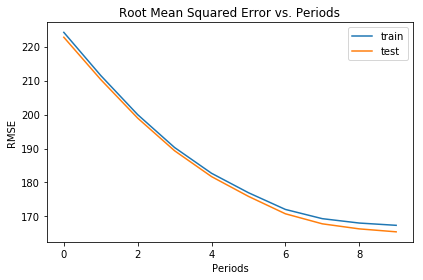

,pred,y
count,13600.0,13600.0
mean,125.3,207.5
std,100.3,116.3
min,0.8,15.0
25%,70.7,119.8
50%,101.4,180.5
75%,149.1,265.0
max,1729.7,500.0


Final RMSE (train, test): 167.37, 165.45


In [12]:
rmse_period = train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)